In [1]:
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
t = np.arange(24*3600)
small_sin = np.sin(2*np.pi*t/30)     # 30 sec
med_cos = 3*np.cos(2*np.pi*t/300)    # 5 min
big_sin = 11*np.sin(2*np.pi*t/1200)  # 20 min
long_saw = 20*signal.sawtooth(2*np.pi*t/1800)  # 30 min
err = 0.75*np.random.randn(len(t))
sig = small_sin + med_cos + big_sin + long_saw + err

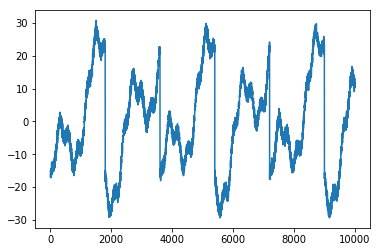

In [4]:
plt.plot(t[:10000],sig[:10000])

In [5]:
from numpy.lib.stride_tricks import as_strided
def make_views(
  arr,
  win_size,
  step_size,
  writeable = False,
):
    """
    arr: any 2D array whose columns are distinct variables and 
    rows are data records at some timestamp t
    win_size: size of data window (given in data points along record/time axis)
    step_size: size of window step (given in data point along record/time axis)
    writable: if True, elements can be modified in new data structure, which will affect
    original array (defaults to False)
  
    Note that step_size is related to window overlap (overlap = win_size - step_size), in 
    case you think in overlaps.
  
    This function can work with C-like and F-like arrays, and with DataFrames.  Yay.
    """
  
    # If DataFrame, use only underlying NumPy array
    if type(arr) == type(pd.DataFrame()):
        arr = arr.values
  
    # Compute Shape Parameter for as_strided
    n_records = arr.shape[0]
    n_columns = arr.shape[1]
    remainder = (n_records - win_size) % step_size 
    num_windows = 1 + int((n_records - win_size - remainder) / step_size)
    shape = (num_windows, win_size, n_columns)
  
    # Compute Strides Parameter for as_strided
    next_win = step_size * arr.strides[0]
    next_row, next_col = arr.strides
    strides = (next_win, next_row, next_col)

    new_view_structure = as_strided(
      arr,
      shape = shape,
      strides = strides,
      writeable = writeable,
    )
    return new_view_structure

In [6]:
# We will create 1801 windows, where first 1800 points are X and last point is y
data = make_views(sig.reshape(-1,1),1801,1)

In [7]:
x = data[:,:1800].squeeze()
y = data[:,1800].ravel()
print('Y shape:',y.shape,'\nX shape:',x.shape)

Y shape: (84600,) 
X shape: (84600, 1800)


I ran a fairly default RF......and it took over an hour before I hit quit.  I saw on some blogs
that people start with very low mtry, e.g., 1 or 2, and build up from there if necessary.  

I also found a package that will estimate your sklearn runtime:
    https://stackoverflow.com/questions/22443041/predicting-how-long-an-scikit-learn-classification-will-take-to-run

In [11]:
!pip install scitime

     |████████████████████████████████| 45.9MB 679kB/s eta 0:00:011
     |████████████████████████████████| 286kB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 440kB 18.7MB/s eta 0:00:01
  Created wheel for psutil: filename=psutil-5.6.3-cp37-cp37m-macosx_10_7_x86_64.whl size=227138 sha256=4878fd9016d5351b29386a7cbc01339eb9017a3306e2249017c8a7c85b6c8d2d
  Stored in directory: /Users/kevinurban/Library/Caches/pip/wheels/90/7e/74/bb640d77775e6b6a78bcc3120f9fea4d2a28b2706de1cff37d
Successfully built psutil
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
from scitime import Estimator

In [25]:
rf = RandomForestRegressor(n_estimators=100, verbose=3, n_jobs=-1, max_features=2)

In [26]:
estimator = Estimator() 
estimation, lower_bound, upper_bound = estimator.time(rf, x, y)

scitime.estimate.Estimator:DEBUG:The model would fit. Moving on
scitime.estimate.Estimator:DEBUG:Fetching estimator: RF_RandomForestRegressor_estimator.pkl
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
scitime.estimate.Estimator:INFO:Training your model for these params: {'total_memory': [17179869184], 'available_memory': [5490036736], 'num_cpu': [8], 'num_rows': [84600], 'num_features': [1800], 'n_estimators': [100], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf':

In [27]:
estimation

103.44621596336364

In [28]:
lower_bound

0.11307097077369689

In [29]:
upper_bound

652.3217680692675

In [30]:
rf.fit(x,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [46]:
p = rf.predict(x)

matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos
matplotlib.axes._base:DEBUG:update_title_pos


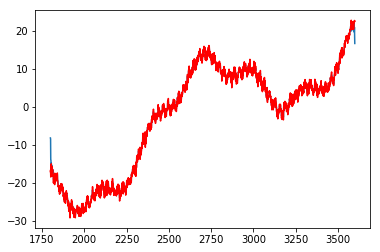

In [52]:
plt.plot(t[1800:3600],p[:1800])
plt.plot(t[1800:3600],y[:1800],'red')

In [58]:
p[10:20]

array([-17.45792533, -16.66044573, -16.38152499, -16.81319206,
       -16.60381716, -17.55936735, -18.16174829, -17.09687317,
       -19.03719583, -18.95191748])

In [60]:
y[10:20]

array([-17.85446569, -17.17131934, -16.67889322, -16.40431803,
       -16.68630458, -17.42980257, -18.23182895, -17.84269074,
       -19.98012345, -19.14373329])

from sklearn.metrics import r2_score

In [57]:
r2_score(y,p)

0.9991296248394299

Wow...

What if we change max_features to 1, like I've seen elsewhere...

In [61]:
rf2 = RandomForestRegressor(n_estimators=100, verbose=3, n_jobs=-1, max_features=1)

In [62]:
rf2.fit(x,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100

building tree 5 of 100building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100

building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100building tree 20 of 100

building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=3, warm_start=False)

In [63]:
p2 = rf2.predict(x)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


In [64]:
r2_score(y,p2)

0.9990300450354151

### Less inputs
So we knew that the largest repetition was 30 minutes...but what if we didn't?

What if we only used 15 minutes of inputs?

In [80]:
data = make_views(sig.reshape(-1,1),901,1)
xx = data[:,:900].squeeze()
yy = data[:,900].ravel()
print('Y shape:',yy.shape,'\nX shape:',xx.shape)

Y shape: (85500,) 
X shape: (85500, 900)


In [81]:
rf3 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features=2)
rf3.fit(xx,yy)
p3 = rf3.predict(xx)

In [82]:
r2_score(yy,p3)

0.9991162786981512

### Even less data
Ok, wow... so 15 minutes still gets 99.91% r2 score.  Same basic score as using 30 minutes of input.

How about if we use 5 minutes?

In [84]:
data = make_views(sig.reshape(-1,1),301,1)
x4 = data[:,:300].squeeze()
y4 = data[:,300].ravel()
print('Y shape:',y4.shape,'\nX shape:',x4.shape)

Y shape: (86100,) 
X shape: (86100, 300)


In [85]:
rf4 = RandomForestRegressor(n_estimators=100, verbose=3, n_jobs=-1, max_features=2)
rf4.fit(x4,y4)
p4 = rf4.predict(x4)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100


building tree 5 of 100building tree 6 of 100
building tree 7 of 100
building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100building tree 21 of 100

building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100building tree 28 of 100

building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


In [86]:
r2_score(y4,p4)

0.9990592426649167

Ok, so using just 5 minutes of data input, we can have 99.906%, where as it is
99.914% with 30 minutes....

How about 1 minute?

In [87]:
data = make_views(sig.reshape(-1,1),61,1)
x5 = data[:,:60].squeeze()
y5 = data[:,60].ravel()
print('Y shape:',y5.shape,'\nX shape:',x5.shape)

Y shape: (86340,) 
X shape: (86340, 60)


In [88]:
rf5 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features=2)
rf5.fit(x5,y5)
p5 = rf5.predict(x5)

In [89]:
r2_score(y5,p5)

0.998867999895426

Ok, wow... So we still get 99.88% accuracy with just one minute of data.

Notice two things: (i) in my quickness to check things, I've not created a validation set, and
(ii) since my signal is purely periodic, the output range in val/test never exceeds the output range
seen in training (i.e., even if I fix issue (i), I still would be getting optimistic results).

Often, one's business is growing, so sales and profits are growing -- and we want to predict how
much we will make next year.  Training on historical data will limit the RF to making predictions
within the historical output range.  Very bad!  (For more info: https://medium.com/datadriveninvestor/why-wont-time-series-data-and-random-forests-work-very-well-together-3c9f7b271631)

One can remedy this somewhat.  For example, one might assume the growth is quasi-linear, and so fit
a linear regression first and subtract it from the data, then use the residuals as inputs to 
the RF.  To avoid target leakage and/or overfitting to the training set here, one might use 50% of
training to do the linear fit, the then other 50% of training (residuals) to do the RF fit.


Also note that, as in the gestures project, the trn/val/tst splits must be done on the original
time series before any windowing is done.  At least, this is an easy way to avoid direct leakage
from training into val/tst.  

In [90]:
trn = round(len(data)*.7)
#val = len(data) - trn
sig_trn = sig[:trn]
data_trn = make_views(sig_trn.reshape(-1,1),61,1)

sig_val = sig[trn:]
data_val = make_views(sig_val.reshape(-1,1),61,1)

win = 60
x_trn1 = data_trn[:,:win].squeeze()
y_trn1 = data_trn[:,win].ravel()

x_val1 = data_val[:,:win].squeeze()
y_val1 = data_val[:,win].ravel()
print('X trn shape:',x_trn1.shape,'\nY trn shape:',y_trn1.shape)

X trn shape: (60378, 60) 
Y trn shape: (60378,)


In [91]:
rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features=2)
rf1.fit(x_trn1,y_trn1)
p1 = rf1.predict(x_val1)

In [92]:
r2_score(y_val1, p1)

0.9912893564114151

## Still works great... Try less data.

In [94]:
trn = round(len(data)*.7)
win = 30
#val = len(data) - trn
sig_trn = sig[:trn]
data_trn = make_views(sig_trn.reshape(-1,1),win+1,1)

sig_val = sig[trn:]
data_val = make_views(sig_val.reshape(-1,1),win+1,1)

x_trn2 = data_trn[:,:win].squeeze()
y_trn2 = data_trn[:,win].ravel()

x_val2 = data_val[:,:win].squeeze()
y_val2 = data_val[:,win].ravel()
print('X trn shape:',x_trn2.shape,'\nY trn shape:',y_trn2.shape)

X trn shape: (60408, 30) 
Y trn shape: (60408,)


In [96]:
rf2 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features=2)
rf2.fit(x_trn2,y_trn2)
p2 = rf2.predict(x_val2)

In [97]:
r2_score(y_val2, p2)

0.9913206821201469

# WTF?  Still good?  

In [98]:
trn = round(len(data)*.7)
win = 10
#val = len(data) - trn
sig_trn = sig[:trn]
data_trn = make_views(sig_trn.reshape(-1,1),win+1,1)

sig_val = sig[trn:]
data_val = make_views(sig_val.reshape(-1,1),win+1,1)

x_trn3 = data_trn[:,:win].squeeze()
y_trn3 = data_trn[:,win].ravel()

x_val3 = data_val[:,:win].squeeze()
y_val3 = data_val[:,win].ravel()
print('X trn shape:',x_trn3.shape,'\nY trn shape:',y_trn3.shape)

X trn shape: (60428, 10) 
Y trn shape: (60428,)


In [99]:
rf3 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features=2)
rf3.fit(x_trn3,y_trn3)
p3 = rf3.predict(x_val3)

In [100]:
r2_score(y_val3, p3)

0.9914895564303101

# Uhhhh

In [101]:
trn = round(len(data)*.7)
win = 3
#val = len(data) - trn
sig_trn = sig[:trn]
data_trn = make_views(sig_trn.reshape(-1,1),win+1,1)

sig_val = sig[trn:]
data_val = make_views(sig_val.reshape(-1,1),win+1,1)

x_trn3 = data_trn[:,:win].squeeze()
y_trn3 = data_trn[:,win].ravel()

x_val3 = data_val[:,:win].squeeze()
y_val3 = data_val[:,win].ravel()
print('X trn shape:',x_trn3.shape,'\nY trn shape:',y_trn3.shape)

X trn shape: (60435, 3) 
Y trn shape: (60435,)


In [102]:
rf3 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features=2)
rf3.fit(x_trn3,y_trn3)
p3 = rf3.predict(x_val3)

In [103]:
r2_score(y_val3, p3)

0.9907066736819914

# Uhhhh.  Uhhhhh.  2?

In [104]:
trn = round(len(data)*.7)
win = 2
#val = len(data) - trn
sig_trn = sig[:trn]
data_trn = make_views(sig_trn.reshape(-1,1),win+1,1)

sig_val = sig[trn:]
data_val = make_views(sig_val.reshape(-1,1),win+1,1)

x_trn3 = data_trn[:,:win].squeeze()
y_trn3 = data_trn[:,win].ravel()

x_val3 = data_val[:,:win].squeeze()
y_val3 = data_val[:,win].ravel()
print('X trn shape:',x_trn3.shape,'\nY trn shape:',y_trn3.shape)

rf3 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features=2)
rf3.fit(x_trn3,y_trn3)
p3 = rf3.predict(x_val3)

r2_score(y_val3, p3)

X trn shape: (60436, 2) 
Y trn shape: (60436,)


0.9897025245752841

### Some Thoughts

These results seem too good to be true.  I still get 99% r2 score (or 98.97%, if you're an asshole).  Like,
wow...  Wtf?  

This could be b/c the curve is slowly varying relative to the sample rate.  If you recall, I have 3 sinusoids
oscillating at 30s, 5m, and 20m, then a sawtooth at 30m.  Other than the 30s wave, 3-dp windows (x1,x2,y) are
fairly constant.  My guess is that the trees just learn to output the same round about number as was entered...

I found a blog that did a very similar analysis, but w/ light curve data from a star.  Same great results.

http://astrohackweek.org/blog/time-series-rf.html

Who needs to know what is going to happen a second from now anyway?  A more realistic
prediction might be:  What will happen 10 minutes from now?

This makes for some interesting windowing/slicing.  Also, do you want to predict *exactly* 10 minutes from
now, or a less noisy 10-30 second avg 10mins from now...?